# 本代码由 ChatGPT 生成，作为个人学习卷积神经网络（CNN）的demo。

<hr>

# 1.导入必要的库
- torch
- torchvision
- pandas
- matplotlib
- pillow
- tqdm
- ipykernel

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

# 2.数据读取

### 2.1 定义train与标签路径

In [10]:
IMG_DIR = '../data/cifar-10/train'
LABELS_FILE = '../data/cifar-10/trainLabels.csv'

### 2.2 自定义Dataset用于迭代读取图片

In [ ]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        # 初始化数据集，加载图像目录和标签文件
        self.img_dir = img_dir
        self.transform = transform
        self.labels = pd.read_csv(labels_file)  # 读取标签文件
        self.labels.set_index('id', inplace=True)  # 将标签文件的索引设置为 'id'

    def __len__(self):
        # 返回数据集的大小
        return len(self.labels)

    def __getitem__(self, idx):
        # 根据索引获取图像和标签
        img_name = f"{self.labels.index[idx]}.png"  # 获取图像文件名
        img_path = os.path.join(self.img_dir, img_name)  # 获取图像路径
        image = Image.open(img_path).convert('RGB')  # 打开图像并转换为 RGB 模式
        if self.transform:
            image = self.transform(image)  # 如果有变换操作，则应用变换
        label = self.labels.loc[self.labels.index[idx], 'label']  # 获取标签
        label = self.label_to_index(label)  # 将标签转换为索引
        return image, label  # 返回图像和标签

    def label_to_index(self, label):
        # 将标签转换为索引
        label_map = {
            'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
            'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
        }
        return label_map[label]

### 2.3 数据增强和训练集验证集构建

In [12]:
# 数据预处理
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# 构造数据集
dataset = CustomCIFAR10Dataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=train_transforms)

# 划分训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 使用不同的变换
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)

# 3.加载ResNet-18模型

In [ ]:
# 检查是否有可用的 GPU，如果有则使用 GPU，否则使用 CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载预训练的 ResNet-18 模型
model = torchvision.models.resnet18(pretrained=True)

# 修改最后一层全连接层，使其输出 10 个类别（对应 CIFAR-10 数据集的 10 个类别）
model.fc = nn.Linear(512, 10)

# 将模型移动到指定设备（GPU 或 CPU）
model = model.to(device)

# 定义损失函数为交叉熵损失
criterion = nn.CrossEntropyLoss()

# 定义优化器为随机梯度下降（SGD），学习率为 0.001，动量为 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 定义梯度缩放器，用于混合精度训练
scaler = GradScaler()

C:\Users\Doog\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Doog\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Doog\AppData\Local\Temp\ipykernel_5008\105165728.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


# 4. 训练

In [ ]:
# 定义训练的轮数
num_epochs = 4

# 初始化列表，用于存储训练损失、训练准确率和验证准确率
train_losses = []
train_accuracies = []
val_accuracies = []

# 开始训练循环
for epoch in range(num_epochs):
    model.train()  # 将模型设置为训练模式
    running_loss = 0.0  # 初始化累计损失
    correct = 0  # 初始化正确预测的计数
    total = 0  # 初始化总样本数
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # 创建进度条

    # 遍历训练数据
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签移动到设备（GPU 或 CPU）
        optimizer.zero_grad()  # 清零梯度
        with autocast():  # 使用混合精度训练
            outputs = model(images)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
        scaler.scale(loss).backward()  # 反向传播并缩放梯度
        scaler.step(optimizer)  # 更新模型参数
        scaler.update()  # 更新缩放器
        running_loss += loss.item()  # 累加损失
        _, predicted = outputs.max(1)  # 获取预测结果
        total += labels.size(0)  # 累加总样本数
        correct += predicted.eq(labels).sum().item()  # 累加正确预测的计数
        progress_bar.set_postfix(loss=running_loss/(total/labels.size(0)), accuracy=100.*correct/total)  # 更新进度条

    # 计算并存储每个 epoch 的训练损失和准确率
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()  # 将模型设置为评估模式
    correct = 0  # 初始化正确预测的计数
    total = 0  # 初始化总样本数
    with torch.no_grad():  # 禁用梯度计算
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # 将图像和标签移动到设备（GPU 或 CPU）
            with autocast():  # 使用混合精度评估
                outputs = model(images)  # 前向传播
            _, predicted = outputs.max(1)  # 获取预测结果
            total += labels.size(0)  # 累加总样本数
            correct += predicted.eq(labels).sum().item()  # 累加正确预测的计数

    # 计算并存储每个 epoch 的验证准确率
    val_acc = 100. * correct / total
    val_accuracies.append(val_acc)

    # 打印每个 epoch 的训练损失、训练准确率和验证准确率
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

Epoch 1/4:   0%|          | 0/313 [00:00<?, ?it/s]C:\Users\Doog\AppData\Local\Temp\ipykernel_5008\4095070014.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/4: 100%|██████████| 313/313 [04:59<00:00,  1.05it/s, accuracy=75.6, loss=0.391]
C:\Users\Doog\AppData\Local\Temp\ipykernel_5008\4095070014.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/4], Loss: 0.7813, Train Acc: 75.64%, Val Acc: 88.84%


Epoch 2/4: 100%|██████████| 313/313 [01:17<00:00,  4.05it/s, accuracy=91, loss=0.142]  


Epoch [2/4], Loss: 0.2830, Train Acc: 91.03%, Val Acc: 91.27%


Epoch 3/4: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s, accuracy=93.9, loss=0.0973]


Epoch [3/4], Loss: 0.1943, Train Acc: 93.92%, Val Acc: 92.33%


Epoch 4/4: 100%|██████████| 313/313 [01:16<00:00,  4.08it/s, accuracy=95.8, loss=0.0701]


Epoch [4/4], Loss: 0.1399, Train Acc: 95.75%, Val Acc: 92.63%


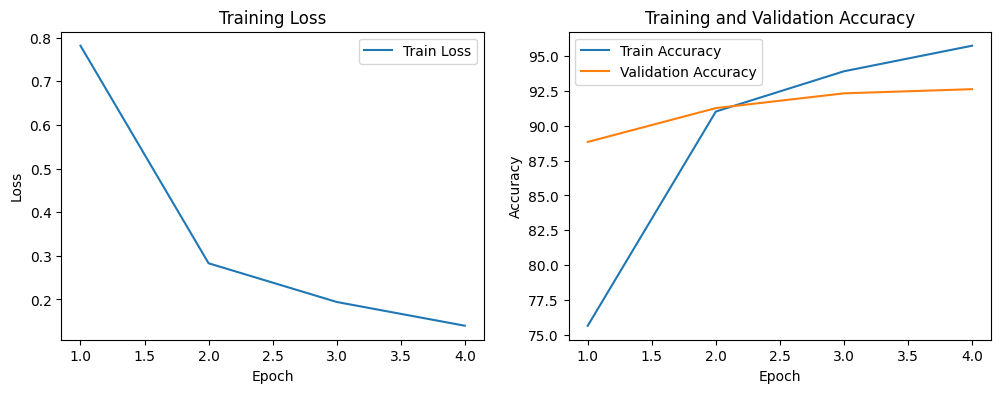

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [16]:
# 保存模型
torch.save(model.state_dict(), 'resnet18_cifar10.pth')

# 5.推理

In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

In [18]:
IMG_DIR = '../data/cifar-10/test'
SUBMISSION_FILE = '../data/cifar-10/submission.csv'

In [ ]:
class CustomCIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')  # 使用 PIL 图像
        if self.transform:
            image = self.transform(image)
        return image, img_name

# 数据预处理
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 构造测试数据集
test_dataset = CustomCIFAR10TestDataset(img_dir=IMG_DIR, transform=test_transforms)

# 数据加载器
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True)

# 定义标签映射
index_to_label = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model = model.to(device)

# 确保模型处于评估模式
model.eval()

# 存储预测结果
predictions = []

with torch.no_grad():
    for images, img_names in tqdm(test_loader, desc="Inference"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        predicted = predicted.cpu().numpy()
        for img_name, pred in zip(img_names, predicted):
            label = index_to_label[pred]
            predictions.append((img_name, label))

# 保存预测结果到 submission.csv
submission_df = pd.DataFrame(predictions, columns=['id', 'label'])
submission_df['id'] = submission_df['id'].str.replace('.png', '')
# submission_df.to_csv('submission.csv', index=False)

C:\Users\Doog\AppData\Local\Temp\ipykernel_5008\2252197813.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_cifar10.pth'))
Inf

In [20]:
# submission id转为int 按照id排序 保存到'../data/cifar-10/submission.csv'
submission_df['id'] = submission_df['id'].astype(int)
submission_df = submission_df.sort_values('id')
submission_df.to_csv(SUBMISSION_FILE, index=False)

In [21]:
submission_df

,id,label
0,1,deer
111111,2,airplane
222222,3,automobile
233334,4,ship
244445,5,airplane
...,...,...
222218,299996,ship
222219,299997,frog
222220,299998,deer
222221,299999,bird
